## **LIBRARIES IMPORTED AND SETUP**

In [1]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random
import seaborn as sns
%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) 

# Setup device (gpu or cpu)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

GPU:  Tesla T4


## **NEW DATASET LOADER**

In [2]:
def get_transforms(size, normalize, split):
    """
    Get data transforms for CIFAR100

    Args:
        size: Image size ('32' or '224')
        normalize: Normalization type ('standard' or 'imagenet')
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
    Returns:
        torchvision.transforms.Compose object
    """
    if normalize == "imagenet":
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == "standard":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    transform_list = []
    # Add data augmentation for training
    if split == "train":
        if size == "224":
            train_transform = transform_list.extend(
                [
                    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
                ]
            )
        elif size == "32":
            train_transform = transform_list.extend(
                [
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                ]
            )
    elif split == "test":
        if size == "224":
            test_transform = transform_list.extend(
                [
                    transforms.Resize((224, 224)),
                ]
            )

    # Add basic transforms
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean, std)])

    return transforms.Compose(transform_list)

In [3]:
def worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)
    random.seed(SEED + worker_id)
    torch.manual_seed(SEED + worker_id)

In [4]:
def CIFAR100DataLoader_v2(
    split,
    batch_size=8,
    num_workers=2,
    shuffle=True,
    size="32",
    normalize="standard",
    seed=42,
):
    """
    A wrapper function that creates a DataLoader for CIFAR100 dataset loaded from torchvision using
    the parameters supplied and applies the required data augmentations.

    Args:
        split: A string to decide if train or test data to be used (Values: 'train', 'test')
        batch_size: Batch size to used for loading data (Default=8)
        num_workers: Number of parallel workers used to load data (Default=2)
        shuffle: Boolean value to decide if data should be randomized (Default=True)
        size: A string to decide the size of the input images (Default='32') (Values: '32','224')
        normalize: A string to decide the normalization to applied to the input images
                   (Default='standard') (Values: 'standard', 'imagenet')

    Output:
        DataLoader Object
    """

    # Get appropriate transforms
    transforms = get_transforms(size, normalize, split)
    if split == "train":
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=True, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )
    else:
        dataset = torchvision.datasets.CIFAR100(
            root="./data", train=False, download=True, transform=transforms
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            shuffle=shuffle,
            worker_init_fn=worker_init_fn,
        )

## **Resnet MODEL SETUP**

In [5]:
class ResidualBlockLarge(nn.Module):
    '''
    ResidualBlockLarge implements the larger block of the Residual Networks. It optionally also downsamples
    the input according to the stride or output channels to match the output while adding the residual. The
    sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> Conv2 -> BNorm2 -> ReLU -> Conv3 -> BNorm3 -> ReLU -> Output
      |                                                                                          |
      |-----------------------------Residual_Downsample (Optional)-------------------------------|

    Args:
        input_channels: Number of input channels
        out_channels: Number of output channels
        residual_downsample: Residual Downsample dependent on if either height, width or channels change
        stride: Stride value for the convolutional layers (Default=1)
        expansion: Expansion of the input channels during convolutions (Default=4)

    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, out_channels * expansion, height, width)

    Examples:
        >>> RBL = ResidualBlockLarge(input_channels, out_channels, residual_downsample, stride, expansion)
        >>> out = RBL(inp)
    '''
    def __init__(self, input_channels, out_channels, residual_downsample=None, stride=1, expansion=4):
        super(ResidualBlockLarge, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * expansion, kernel_size=1, stride=1, padding=0)
        self.bnorm3 = nn.BatchNorm2d(out_channels * expansion)
        self.activation = nn.ReLU()
        self.residual_downsample = residual_downsample

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        res = inp
        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.activation(self.bnorm2(self.conv2(out)))
        out = self.activation(self.bnorm3(self.conv3(out)))

        if self.residual_downsample is not None:
            res = self.residual_downsample(res)

        out = self.activation(out + res)

        # out: (batch_size, out_channels * expansion, height, width) | height, width depending on stride
        return out
        
class ResNetLarge(nn.Module):
    '''
    ResNetLarge consists of layers of the larger residual block defined above (ResidualBlockLarger).
    The layers are the residual blocks. The sequence of operations is as follows :-

    Input -> Conv1 -> BNorm1 -> ReLU -> MaxPool -> Layer1 -> Layer2 -> Layer3 -> Layer4 -> AvgPool -> FC

    Args:
        layers: A four value array containing number of conv layers in each residual block
        input_channels: number of input channels
        classes: Number of classes in the dataset

    Methods:
        _layer(num_layers (Number of conv layers)
               ,input_channels (Number of input channels)
               ,output_channels (Number of output channels)
               ,stride (Stride value for conv layer)) :-
        Returns the sequential wrapper with all the layers in the residual block constructed according
        to the parameters.

        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, input_channels, height, width) -> (batch_size, classes)

    Examples:
        >>> resnet = ResNetLarge(layers, input_channels, classes)
        >>> out = resnet(inp)
    '''
    def __init__(self, layers, input_channels, classes):
        super(ResNetLarge, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bnorm1 = nn.BatchNorm2d(64)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._layer(layers[0], input_channels=64, output_channels=64, stride=1)
        self.layer2 = self._layer(layers[1], input_channels=256, output_channels=128, stride=2)
        self.layer3 = self._layer(layers[2], input_channels=512, output_channels=256, stride=2)
        self.layer4 = self._layer(layers[3], input_channels=1024, output_channels=512, stride=2)

        self.avppool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, classes)

    def forward(self, inp):
        # inp: (batch_size, input_channels, height, width)

        out = self.activation(self.bnorm1(self.conv1(inp)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avppool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        # out: (batch_size, classes)
        return out

    def _layer(self, num_layers, input_channels, output_channels, stride):
        residual_downsample = None
        layers = []

        # Checks if there would be potential mismatch in any of height, width or channels between input and output.
        # 4 is the value of the expansion for large ResNets
        if stride != 1 or input_channels != output_channels * 4:
            residual_downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels * 4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channels * 4)
            )

        layers.append(ResidualBlockLarge(input_channels, output_channels, residual_downsample, stride))

        for i in range(num_layers - 1):
            layers.append(ResidualBlockLarge(output_channels * 4, output_channels))

        return nn.Sequential(*layers)

def ResNet50(input_channels, classes):
    '''
    Initalization of ResNet50 using the layers as mentioned in the paper and using ResNetLarge module.

    Args:
        input_channels: Number of input channels
        classes: Number of classes in the dataset

    Output:
        ResNetLarge Object
    '''
    return ResNetLarge([3, 4, 6, 3], input_channels, classes)

## **TRAINING, EVALUATION AND TESTING FUNCTION**

In [6]:
# Training model
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):
    """
    Function used to train the model over a single epoch and update it according to the
    calculated gradients.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        optimizer: Optimizer used update the model
        scheduler: Scheduler used to update the learing rate for faster convergence
                   (Commented out due to poor results)
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        running_loss: Training Loss (Float)
        running_accuracy: Training Accuracy (Float)
    """
    running_loss = 0.0
    running_accuracy = 0.0
    index = 0
    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)
        if model.name == "VisionTransformer":
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == "ResNet":
            output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy


# Validation model
def evaluation(model, dataloader, criterion, resnet_features=None):
    """
    Function used to evaluate the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        criterion: Criterion used to calculate loss
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        test_loss: Testing Loss (Float)
        test_accuracy: Testing Accuracy (Float)
    """
    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy


def test(model, dataloader, resnet_features=None):
    """
    Function used to test the model on the test dataset.

    Args:
        model: Model supplied to the function
        dataloader: DataLoader supplied to the function
        resnet_features: Model to get Resnet Features for the hybrid architecture (Default=None)

    Output:
        all_preds: All model predict label (Int)
        all_labels: All dataset label (Int)
    """
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for data, label in tqdm(dataloader):
            data = data.to(device)
            target = label.to(device)

            if model.name == "VisionTransformer":
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == "ResNet":
                output = model(data)

            pred = output.argmax(dim=1)
            all_preds.extend(pred)
            all_labels.extend(label)

    return all_preds, all_labels

## **INITIALIZE VARIABLE**

In [7]:
max_len = 100  # All sequences must be less than 1000 including class token
classes = 100
image_sz = 32
channels = 3

lr = 0.001
epochs = 100

patch_size = 16
batch_size = 32
num_workers = 2
shuffle = True

embed_dim = 768

layers = 12
heads = 12

resnet_features_channels = 64

In [8]:
# Init model
model = ResNet50(
    input_channels=channels,
    classes=classes).to(device)

resnet_features = None

## **TRAINING AND TEST**

In [9]:
# Init data loader
train_dataloader = CIFAR100DataLoader_v2(
    split="train",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=shuffle,
    size="32",
    normalize="standard",
)
test_dataloader = CIFAR100DataLoader_v2(
    split="test",
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    size="32",
    normalize="standard",
)

100%|██████████| 169001437/169001437 [00:02<00:00, 61207136.97it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
# Initialize first time training
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs
)

train_accs = []
test_accs = []
last_epoch = 0

In [11]:
# Record the start time
start_time = time.time()
# Running
for epoch in range(epochs - last_epoch):
    epoch += last_epoch
    running_loss, running_accuracy = train(
        model, train_dataloader, criterion, optimizer, scheduler, resnet_features
    )
    print(
        f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n"
    )
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(
        model, test_dataloader, criterion, resnet_features
    )
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch + 1) % 10 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model": model,
                "optimizer": optimizer,
                "scheduler": scheduler,
                "train_acc": train_accs,
                "test_acc": test_accs,
            },
            model.name + "_CIFAR100_checkpoint_" + str(epoch) + ".pt",
        )

torch.save(
    {
        "epoch": epoch,
        "model": model,
        "optimizer": optimizer,
        "scheduler": scheduler,
        "train_acc": train_accs,
        "test_acc": test_accs,
    },
    model.name + "_CIFAR100.pt",
)

# Record the end time
end_time = time.time()
# Calculate the time difference
time_difference = end_time - start_time

print(f"Start Time: {start_time}")
print(f"End Time: {end_time}")
# print(f"Time Taken: {time_difference} seconds")

100%|██████████| 1563/1563 [01:04<00:00, 24.31it/s]


Epoch : 1 - acc: 0.0563 - loss : 4.3245



100%|██████████| 313/313 [00:04<00:00, 71.69it/s]


test acc: 0.0948 - test loss : 3.9645



100%|██████████| 1563/1563 [01:03<00:00, 24.62it/s]


Epoch : 2 - acc: 0.1154 - loss : 3.8402



100%|██████████| 313/313 [00:04<00:00, 71.22it/s]


test acc: 0.1465 - test loss : 3.6483



100%|██████████| 1563/1563 [01:03<00:00, 24.56it/s]


Epoch : 3 - acc: 0.1499 - loss : 3.6110



100%|██████████| 313/313 [00:03<00:00, 78.60it/s]


test acc: 0.1842 - test loss : 3.4323



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 4 - acc: 0.1814 - loss : 3.4193



100%|██████████| 313/313 [00:04<00:00, 72.56it/s]


test acc: 0.2081 - test loss : 3.2551



100%|██████████| 1563/1563 [01:05<00:00, 23.87it/s]


Epoch : 5 - acc: 0.2087 - loss : 3.2510



100%|██████████| 313/313 [00:04<00:00, 76.17it/s]


test acc: 0.2346 - test loss : 3.1397



100%|██████████| 1563/1563 [01:05<00:00, 23.88it/s]


Epoch : 6 - acc: 0.2356 - loss : 3.1129



100%|██████████| 313/313 [00:04<00:00, 68.96it/s]


test acc: 0.2534 - test loss : 3.0346



100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s]


Epoch : 7 - acc: 0.2598 - loss : 2.9780



100%|██████████| 313/313 [00:04<00:00, 75.49it/s]


test acc: 0.2733 - test loss : 2.9392



100%|██████████| 1563/1563 [01:05<00:00, 23.82it/s]


Epoch : 8 - acc: 0.2807 - loss : 2.8625



100%|██████████| 313/313 [00:03<00:00, 78.71it/s]


test acc: 0.2949 - test loss : 2.8510



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 9 - acc: 0.3037 - loss : 2.7592



100%|██████████| 313/313 [00:04<00:00, 74.98it/s]


test acc: 0.3049 - test loss : 2.7920



100%|██████████| 1563/1563 [01:05<00:00, 23.90it/s]


Epoch : 10 - acc: 0.3209 - loss : 2.6521



100%|██████████| 313/313 [00:03<00:00, 83.22it/s]


test acc: 0.3153 - test loss : 2.7081



100%|██████████| 1563/1563 [01:05<00:00, 23.84it/s]


Epoch : 11 - acc: 0.3413 - loss : 2.5620



100%|██████████| 313/313 [00:04<00:00, 71.34it/s]


test acc: 0.3342 - test loss : 2.6456



100%|██████████| 1563/1563 [01:05<00:00, 23.83it/s]


Epoch : 12 - acc: 0.3564 - loss : 2.4780



100%|██████████| 313/313 [00:04<00:00, 75.17it/s]


test acc: 0.3525 - test loss : 2.5653



100%|██████████| 1563/1563 [01:05<00:00, 24.00it/s]


Epoch : 13 - acc: 0.3763 - loss : 2.3922



100%|██████████| 313/313 [00:04<00:00, 75.20it/s]


test acc: 0.3644 - test loss : 2.5062



100%|██████████| 1563/1563 [01:05<00:00, 23.93it/s]


Epoch : 14 - acc: 0.3908 - loss : 2.3219



100%|██████████| 313/313 [00:04<00:00, 72.32it/s]


test acc: 0.3723 - test loss : 2.4735



100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]


Epoch : 15 - acc: 0.4083 - loss : 2.2470



100%|██████████| 313/313 [00:04<00:00, 77.13it/s]


test acc: 0.3723 - test loss : 2.4643



100%|██████████| 1563/1563 [01:05<00:00, 23.93it/s]


Epoch : 16 - acc: 0.4249 - loss : 2.1776



100%|██████████| 313/313 [00:04<00:00, 75.40it/s]


test acc: 0.3803 - test loss : 2.4299



100%|██████████| 1563/1563 [01:05<00:00, 23.90it/s]


Epoch : 17 - acc: 0.4344 - loss : 2.1150



100%|██████████| 313/313 [00:04<00:00, 74.38it/s]


test acc: 0.3933 - test loss : 2.3665



100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]


Epoch : 18 - acc: 0.4470 - loss : 2.0557



100%|██████████| 313/313 [00:04<00:00, 71.94it/s]


test acc: 0.3980 - test loss : 2.3631



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 19 - acc: 0.4675 - loss : 1.9732



100%|██████████| 313/313 [00:04<00:00, 75.07it/s]


test acc: 0.3980 - test loss : 2.3707



100%|██████████| 1563/1563 [01:04<00:00, 24.27it/s]


Epoch : 20 - acc: 0.4782 - loss : 1.9092



100%|██████████| 313/313 [00:04<00:00, 75.02it/s]


test acc: 0.4106 - test loss : 2.3216



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 21 - acc: 0.4906 - loss : 1.8562



100%|██████████| 313/313 [00:04<00:00, 70.57it/s]


test acc: 0.4133 - test loss : 2.3117



100%|██████████| 1563/1563 [01:04<00:00, 24.20it/s]


Epoch : 22 - acc: 0.5085 - loss : 1.7987



100%|██████████| 313/313 [00:04<00:00, 71.54it/s]


test acc: 0.4196 - test loss : 2.3127



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 23 - acc: 0.5193 - loss : 1.7406



100%|██████████| 313/313 [00:04<00:00, 73.05it/s]


test acc: 0.4180 - test loss : 2.2770



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 24 - acc: 0.5287 - loss : 1.6892



100%|██████████| 313/313 [00:03<00:00, 79.02it/s]


test acc: 0.4206 - test loss : 2.2996



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 25 - acc: 0.5424 - loss : 1.6260



100%|██████████| 313/313 [00:04<00:00, 72.21it/s]


test acc: 0.4159 - test loss : 2.3052



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 26 - acc: 0.5571 - loss : 1.5637



100%|██████████| 313/313 [00:04<00:00, 71.70it/s]


test acc: 0.4229 - test loss : 2.3022



100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s]


Epoch : 27 - acc: 0.5738 - loss : 1.5152



100%|██████████| 313/313 [00:04<00:00, 75.05it/s]


test acc: 0.4263 - test loss : 2.3003



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 28 - acc: 0.5876 - loss : 1.4551



100%|██████████| 313/313 [00:04<00:00, 75.86it/s]


test acc: 0.4273 - test loss : 2.3102



100%|██████████| 1563/1563 [01:04<00:00, 24.38it/s]


Epoch : 29 - acc: 0.6008 - loss : 1.3949



100%|██████████| 313/313 [00:04<00:00, 73.80it/s]


test acc: 0.4244 - test loss : 2.3316



100%|██████████| 1563/1563 [01:04<00:00, 24.23it/s]


Epoch : 30 - acc: 0.6113 - loss : 1.3540



100%|██████████| 313/313 [00:04<00:00, 69.93it/s]


test acc: 0.4280 - test loss : 2.3129



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 31 - acc: 0.6272 - loss : 1.2919



100%|██████████| 313/313 [00:04<00:00, 68.55it/s]


test acc: 0.4299 - test loss : 2.3546



100%|██████████| 1563/1563 [01:04<00:00, 24.24it/s]


Epoch : 32 - acc: 0.6384 - loss : 1.2457



100%|██████████| 313/313 [00:04<00:00, 70.61it/s]


test acc: 0.4297 - test loss : 2.3592



100%|██████████| 1563/1563 [01:04<00:00, 24.41it/s]


Epoch : 33 - acc: 0.6511 - loss : 1.1934



100%|██████████| 313/313 [00:03<00:00, 80.56it/s]


test acc: 0.4293 - test loss : 2.3715



100%|██████████| 1563/1563 [01:04<00:00, 24.42it/s]


Epoch : 34 - acc: 0.6639 - loss : 1.1419



100%|██████████| 313/313 [00:03<00:00, 81.25it/s]


test acc: 0.4351 - test loss : 2.3730



100%|██████████| 1563/1563 [01:04<00:00, 24.31it/s]


Epoch : 35 - acc: 0.6744 - loss : 1.0932



100%|██████████| 313/313 [00:04<00:00, 78.12it/s]


test acc: 0.4290 - test loss : 2.4172



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 36 - acc: 0.6886 - loss : 1.0512



100%|██████████| 313/313 [00:03<00:00, 78.54it/s]


test acc: 0.4392 - test loss : 2.4195



100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 37 - acc: 0.7000 - loss : 1.0053



100%|██████████| 313/313 [00:04<00:00, 75.33it/s]


test acc: 0.4353 - test loss : 2.4256



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 38 - acc: 0.7076 - loss : 0.9669



100%|██████████| 313/313 [00:04<00:00, 67.63it/s]


test acc: 0.4363 - test loss : 2.4564



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 39 - acc: 0.7214 - loss : 0.9242



100%|██████████| 313/313 [00:03<00:00, 78.80it/s]


test acc: 0.4274 - test loss : 2.5198



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 40 - acc: 0.7333 - loss : 0.8811



100%|██████████| 313/313 [00:04<00:00, 72.23it/s]


test acc: 0.4400 - test loss : 2.4874



100%|██████████| 1563/1563 [01:04<00:00, 24.27it/s]


Epoch : 41 - acc: 0.7449 - loss : 0.8425



100%|██████████| 313/313 [00:04<00:00, 77.31it/s]


test acc: 0.4347 - test loss : 2.5418



100%|██████████| 1563/1563 [01:04<00:00, 24.30it/s]


Epoch : 42 - acc: 0.7542 - loss : 0.8033



100%|██████████| 313/313 [00:04<00:00, 72.40it/s]


test acc: 0.4264 - test loss : 2.5673



100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 43 - acc: 0.7660 - loss : 0.7714



100%|██████████| 313/313 [00:04<00:00, 70.89it/s]


test acc: 0.4349 - test loss : 2.5514



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 44 - acc: 0.7717 - loss : 0.7363



100%|██████████| 313/313 [00:03<00:00, 79.03it/s]


test acc: 0.4334 - test loss : 2.6111



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 45 - acc: 0.7816 - loss : 0.7080



100%|██████████| 313/313 [00:03<00:00, 80.35it/s]


test acc: 0.4282 - test loss : 2.6363



100%|██████████| 1563/1563 [01:04<00:00, 24.06it/s]


Epoch : 46 - acc: 0.7934 - loss : 0.6707



100%|██████████| 313/313 [00:04<00:00, 75.76it/s]


test acc: 0.4295 - test loss : 2.6850



100%|██████████| 1563/1563 [01:04<00:00, 24.22it/s]


Epoch : 47 - acc: 0.8017 - loss : 0.6430



100%|██████████| 313/313 [00:03<00:00, 78.77it/s]


test acc: 0.4295 - test loss : 2.7142



100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


Epoch : 48 - acc: 0.8070 - loss : 0.6211



100%|██████████| 313/313 [00:04<00:00, 74.39it/s]


test acc: 0.4258 - test loss : 2.7470



100%|██████████| 1563/1563 [01:04<00:00, 24.25it/s]


Epoch : 49 - acc: 0.8160 - loss : 0.5939



100%|██████████| 313/313 [00:04<00:00, 71.14it/s]


test acc: 0.4304 - test loss : 2.7514



100%|██████████| 1563/1563 [01:04<00:00, 24.26it/s]


Epoch : 50 - acc: 0.8236 - loss : 0.5652



100%|██████████| 313/313 [00:04<00:00, 73.53it/s]


test acc: 0.4323 - test loss : 2.7679



100%|██████████| 1563/1563 [01:04<00:00, 24.33it/s]


Epoch : 51 - acc: 0.8240 - loss : 0.5614



100%|██████████| 313/313 [00:04<00:00, 75.71it/s]


test acc: 0.4354 - test loss : 2.7875



100%|██████████| 1563/1563 [01:04<00:00, 24.25it/s]


Epoch : 52 - acc: 0.8372 - loss : 0.5229



100%|██████████| 313/313 [00:04<00:00, 73.65it/s]


test acc: 0.4232 - test loss : 2.8702



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 53 - acc: 0.8407 - loss : 0.5057



100%|██████████| 313/313 [00:04<00:00, 77.93it/s]


test acc: 0.4330 - test loss : 2.8653



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 54 - acc: 0.8455 - loss : 0.4908



100%|██████████| 313/313 [00:04<00:00, 71.99it/s]


test acc: 0.4281 - test loss : 2.9187



100%|██████████| 1563/1563 [01:04<00:00, 24.35it/s]


Epoch : 55 - acc: 0.8498 - loss : 0.4738



100%|██████████| 313/313 [00:04<00:00, 73.90it/s]


test acc: 0.4267 - test loss : 2.9140



100%|██████████| 1563/1563 [01:04<00:00, 24.32it/s]


Epoch : 56 - acc: 0.8559 - loss : 0.4558



100%|██████████| 313/313 [00:04<00:00, 73.96it/s]


test acc: 0.4277 - test loss : 2.9708



100%|██████████| 1563/1563 [01:05<00:00, 23.85it/s]


Epoch : 57 - acc: 0.8590 - loss : 0.4448



100%|██████████| 313/313 [00:04<00:00, 74.22it/s]


test acc: 0.4312 - test loss : 2.9416



100%|██████████| 1563/1563 [01:05<00:00, 24.03it/s]


Epoch : 58 - acc: 0.8628 - loss : 0.4346



100%|██████████| 313/313 [00:04<00:00, 70.42it/s]


test acc: 0.4355 - test loss : 2.9250



100%|██████████| 1563/1563 [01:06<00:00, 23.47it/s]


Epoch : 59 - acc: 0.8679 - loss : 0.4183



100%|██████████| 313/313 [00:04<00:00, 75.22it/s]


test acc: 0.4296 - test loss : 2.9481



100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch : 60 - acc: 0.8683 - loss : 0.4129



100%|██████████| 313/313 [00:04<00:00, 73.94it/s]


test acc: 0.4289 - test loss : 3.0073



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 61 - acc: 0.8780 - loss : 0.3867



100%|██████████| 313/313 [00:04<00:00, 73.81it/s]


test acc: 0.4294 - test loss : 2.9896



100%|██████████| 1563/1563 [01:05<00:00, 23.93it/s]


Epoch : 62 - acc: 0.8834 - loss : 0.3693



100%|██████████| 313/313 [00:04<00:00, 76.77it/s]


test acc: 0.4259 - test loss : 3.0606



100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]


Epoch : 63 - acc: 0.8815 - loss : 0.3731



100%|██████████| 313/313 [00:03<00:00, 78.31it/s]


test acc: 0.4227 - test loss : 3.0664



100%|██████████| 1563/1563 [01:05<00:00, 23.96it/s]


Epoch : 64 - acc: 0.8889 - loss : 0.3517



100%|██████████| 313/313 [00:04<00:00, 71.87it/s]


test acc: 0.4292 - test loss : 3.0344



100%|██████████| 1563/1563 [01:05<00:00, 23.89it/s]


Epoch : 65 - acc: 0.8934 - loss : 0.3394



100%|██████████| 313/313 [00:04<00:00, 75.35it/s]


test acc: 0.4273 - test loss : 3.0906



100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]


Epoch : 66 - acc: 0.8926 - loss : 0.3395



100%|██████████| 313/313 [00:04<00:00, 69.10it/s]


test acc: 0.4279 - test loss : 3.1279



100%|██████████| 1563/1563 [01:05<00:00, 23.92it/s]


Epoch : 67 - acc: 0.8967 - loss : 0.3240



100%|██████████| 313/313 [00:04<00:00, 74.89it/s]


test acc: 0.4370 - test loss : 3.1316



100%|██████████| 1563/1563 [01:05<00:00, 23.82it/s]


Epoch : 68 - acc: 0.8976 - loss : 0.3198



100%|██████████| 313/313 [00:04<00:00, 76.23it/s]


test acc: 0.4309 - test loss : 3.1649



100%|██████████| 1563/1563 [01:05<00:00, 24.02it/s]


Epoch : 69 - acc: 0.8999 - loss : 0.3129



100%|██████████| 313/313 [00:04<00:00, 69.34it/s]


test acc: 0.4343 - test loss : 3.1518



100%|██████████| 1563/1563 [01:05<00:00, 23.72it/s]


Epoch : 70 - acc: 0.9019 - loss : 0.3071



100%|██████████| 313/313 [00:04<00:00, 70.84it/s]


test acc: 0.4351 - test loss : 3.1506



100%|██████████| 1563/1563 [01:05<00:00, 23.98it/s]


Epoch : 71 - acc: 0.9073 - loss : 0.2866



100%|██████████| 313/313 [00:03<00:00, 79.74it/s]


test acc: 0.4362 - test loss : 3.1958



100%|██████████| 1563/1563 [01:04<00:00, 24.18it/s]


Epoch : 72 - acc: 0.9075 - loss : 0.2951



100%|██████████| 313/313 [00:04<00:00, 75.67it/s]


test acc: 0.4279 - test loss : 3.2210



100%|██████████| 1563/1563 [01:05<00:00, 24.03it/s]


Epoch : 73 - acc: 0.9081 - loss : 0.2901



100%|██████████| 313/313 [00:04<00:00, 68.75it/s]


test acc: 0.4324 - test loss : 3.2239



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 74 - acc: 0.9128 - loss : 0.2720



100%|██████████| 313/313 [00:04<00:00, 68.76it/s]


test acc: 0.4297 - test loss : 3.2666



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 75 - acc: 0.9111 - loss : 0.2757



100%|██████████| 313/313 [00:04<00:00, 74.35it/s]


test acc: 0.4317 - test loss : 3.2554



100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


Epoch : 76 - acc: 0.9161 - loss : 0.2655



100%|██████████| 313/313 [00:04<00:00, 75.44it/s]


test acc: 0.4340 - test loss : 3.2285



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 77 - acc: 0.9177 - loss : 0.2591



100%|██████████| 313/313 [00:04<00:00, 68.90it/s]


test acc: 0.4356 - test loss : 3.2738



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 78 - acc: 0.9221 - loss : 0.2467



100%|██████████| 313/313 [00:04<00:00, 78.12it/s]


test acc: 0.4317 - test loss : 3.3027



100%|██████████| 1563/1563 [01:05<00:00, 24.04it/s]


Epoch : 79 - acc: 0.9188 - loss : 0.2536



100%|██████████| 313/313 [00:04<00:00, 69.45it/s]


test acc: 0.4347 - test loss : 3.3067



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 80 - acc: 0.9232 - loss : 0.2417



100%|██████████| 313/313 [00:04<00:00, 75.36it/s]


test acc: 0.4335 - test loss : 3.3450



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 81 - acc: 0.9229 - loss : 0.2398



100%|██████████| 313/313 [00:03<00:00, 79.33it/s]


test acc: 0.4296 - test loss : 3.3242



100%|██████████| 1563/1563 [01:04<00:00, 24.09it/s]


Epoch : 82 - acc: 0.9265 - loss : 0.2278



100%|██████████| 313/313 [00:04<00:00, 64.58it/s]


test acc: 0.4310 - test loss : 3.3843



100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]


Epoch : 83 - acc: 0.9250 - loss : 0.2328



100%|██████████| 313/313 [00:04<00:00, 71.62it/s]


test acc: 0.4269 - test loss : 3.4018



100%|██████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch : 84 - acc: 0.9264 - loss : 0.2260



100%|██████████| 313/313 [00:04<00:00, 69.62it/s]


test acc: 0.4315 - test loss : 3.4011



100%|██████████| 1563/1563 [01:04<00:00, 24.14it/s]


Epoch : 85 - acc: 0.9277 - loss : 0.2251



100%|██████████| 313/313 [00:04<00:00, 71.81it/s]


test acc: 0.4366 - test loss : 3.3954



100%|██████████| 1563/1563 [01:05<00:00, 23.94it/s]


Epoch : 86 - acc: 0.9298 - loss : 0.2154



100%|██████████| 313/313 [00:04<00:00, 76.09it/s]


test acc: 0.4291 - test loss : 3.4123



100%|██████████| 1563/1563 [01:04<00:00, 24.07it/s]


Epoch : 87 - acc: 0.9318 - loss : 0.2157



100%|██████████| 313/313 [00:03<00:00, 79.49it/s]


test acc: 0.4257 - test loss : 3.4711



100%|██████████| 1563/1563 [01:04<00:00, 24.12it/s]


Epoch : 88 - acc: 0.9308 - loss : 0.2141



100%|██████████| 313/313 [00:04<00:00, 78.20it/s]


test acc: 0.4306 - test loss : 3.4757



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 89 - acc: 0.9342 - loss : 0.2083



100%|██████████| 313/313 [00:04<00:00, 73.61it/s]


test acc: 0.4277 - test loss : 3.4816



100%|██████████| 1563/1563 [01:04<00:00, 24.13it/s]


Epoch : 90 - acc: 0.9341 - loss : 0.2052



100%|██████████| 313/313 [00:04<00:00, 72.35it/s]


test acc: 0.4395 - test loss : 3.3966



100%|██████████| 1563/1563 [01:04<00:00, 24.08it/s]


Epoch : 91 - acc: 0.9346 - loss : 0.2038



100%|██████████| 313/313 [00:03<00:00, 80.13it/s]


test acc: 0.4280 - test loss : 3.4787



100%|██████████| 1563/1563 [01:05<00:00, 24.05it/s]


Epoch : 92 - acc: 0.9370 - loss : 0.1962



100%|██████████| 313/313 [00:04<00:00, 76.60it/s]


test acc: 0.4318 - test loss : 3.4440



100%|██████████| 1563/1563 [01:04<00:00, 24.15it/s]


Epoch : 93 - acc: 0.9365 - loss : 0.2007



100%|██████████| 313/313 [00:04<00:00, 71.24it/s]


test acc: 0.4314 - test loss : 3.4891



100%|██████████| 1563/1563 [01:04<00:00, 24.19it/s]


Epoch : 94 - acc: 0.9405 - loss : 0.1875



100%|██████████| 313/313 [00:04<00:00, 69.28it/s]


test acc: 0.4354 - test loss : 3.4757



100%|██████████| 1563/1563 [01:04<00:00, 24.34it/s]


Epoch : 95 - acc: 0.9386 - loss : 0.1928



100%|██████████| 313/313 [00:04<00:00, 70.71it/s]


test acc: 0.4344 - test loss : 3.4951



100%|██████████| 1563/1563 [01:04<00:00, 24.29it/s]


Epoch : 96 - acc: 0.9419 - loss : 0.1856



100%|██████████| 313/313 [00:03<00:00, 78.43it/s]


test acc: 0.4389 - test loss : 3.5088



100%|██████████| 1563/1563 [01:04<00:00, 24.16it/s]


Epoch : 97 - acc: 0.9404 - loss : 0.1867



100%|██████████| 313/313 [00:04<00:00, 74.79it/s]


test acc: 0.4342 - test loss : 3.4877



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 98 - acc: 0.9413 - loss : 0.1815



100%|██████████| 313/313 [00:04<00:00, 76.48it/s]


test acc: 0.4393 - test loss : 3.5022



100%|██████████| 1563/1563 [01:05<00:00, 24.01it/s]


Epoch : 99 - acc: 0.9436 - loss : 0.1777



100%|██████████| 313/313 [00:03<00:00, 79.52it/s]


test acc: 0.4332 - test loss : 3.5140



100%|██████████| 1563/1563 [01:04<00:00, 24.17it/s]


Epoch : 100 - acc: 0.9429 - loss : 0.1770



100%|██████████| 313/313 [00:04<00:00, 69.50it/s]


test acc: 0.4274 - test loss : 3.5148

Start Time: 1735314213.3963826
End Time: 1735321120.6919155


In [12]:
superclass_to_classes = {
    "aquatic_mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food_containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit_and_vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household_electrical_devices": [
        "clock",
        "keyboard",
        "lamp",
        "telephone",
        "television",
    ],
    "household_furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large_carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large_man-made_outdoor_things": [
        "bridge",
        "castle",
        "house",
        "road",
        "skyscraper",
    ],
    "large_natural_outdoor_scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large_omnivores_and_herbivores": [
        "camel",
        "cattle",
        "chimpanzee",
        "elephant",
        "kangaroo",
    ],
    "medium-sized_mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect_invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small_mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles_1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles_2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
}

classes_to_superclass = {}

for superclass, classes in superclass_to_classes.items():
    for class_name in classes:
        classes_to_superclass[class_name] = superclass

child_class = test_dataloader.dataset.classes


def get_super_by_child(child):
    return classes_to_superclass[child]


def list_superclass_label(labels):
    """
    Function convert list of child class id to list of super class

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of super class label (List<Int>)
    """
    return [get_super_by_child(child_class[label]) for label in labels]


def list_class_label(labels):
    """
    Function convert list of child class id to list of child class label

    Args:
        labels: list of child class label id

    Output:
        super_labels: List of child class label (List<String>)
    """
    return [child_class[label] for label in labels]

Train and test accuracy

<ipython-input-13-053996e4518c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


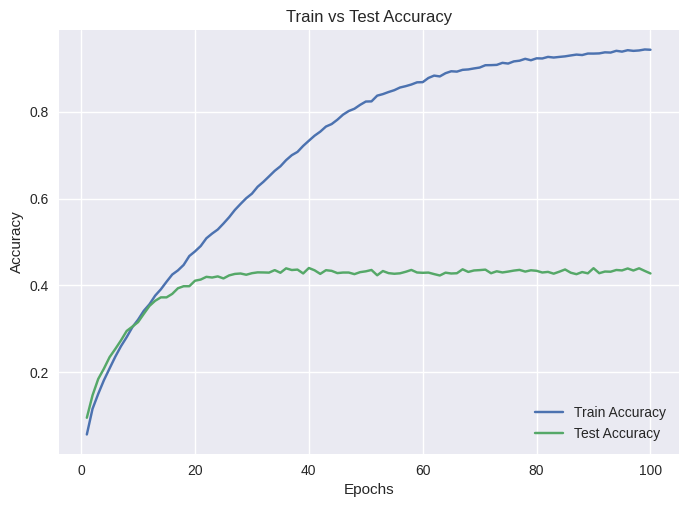

In [13]:
plt.style.use("seaborn")
train_accs_data = [acc.cpu().item() for acc in train_accs]
test_accs_data = [acc.cpu().item() for acc in test_accs]
plt.plot(range(1, 101), train_accs_data, label="Train Accuracy")
plt.plot(range(1, 101), test_accs_data, label="Test Accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc="lower right")

In [14]:
pred_labels ,true_labels = test(model, test_dataloader)
true_labels = [label.cpu().item() for label in true_labels]
pred_labels = [label.cpu().item() for label in pred_labels]

100%|██████████| 313/313 [00:03<00:00, 88.98it/s] 


####  Superclass confusion matrix

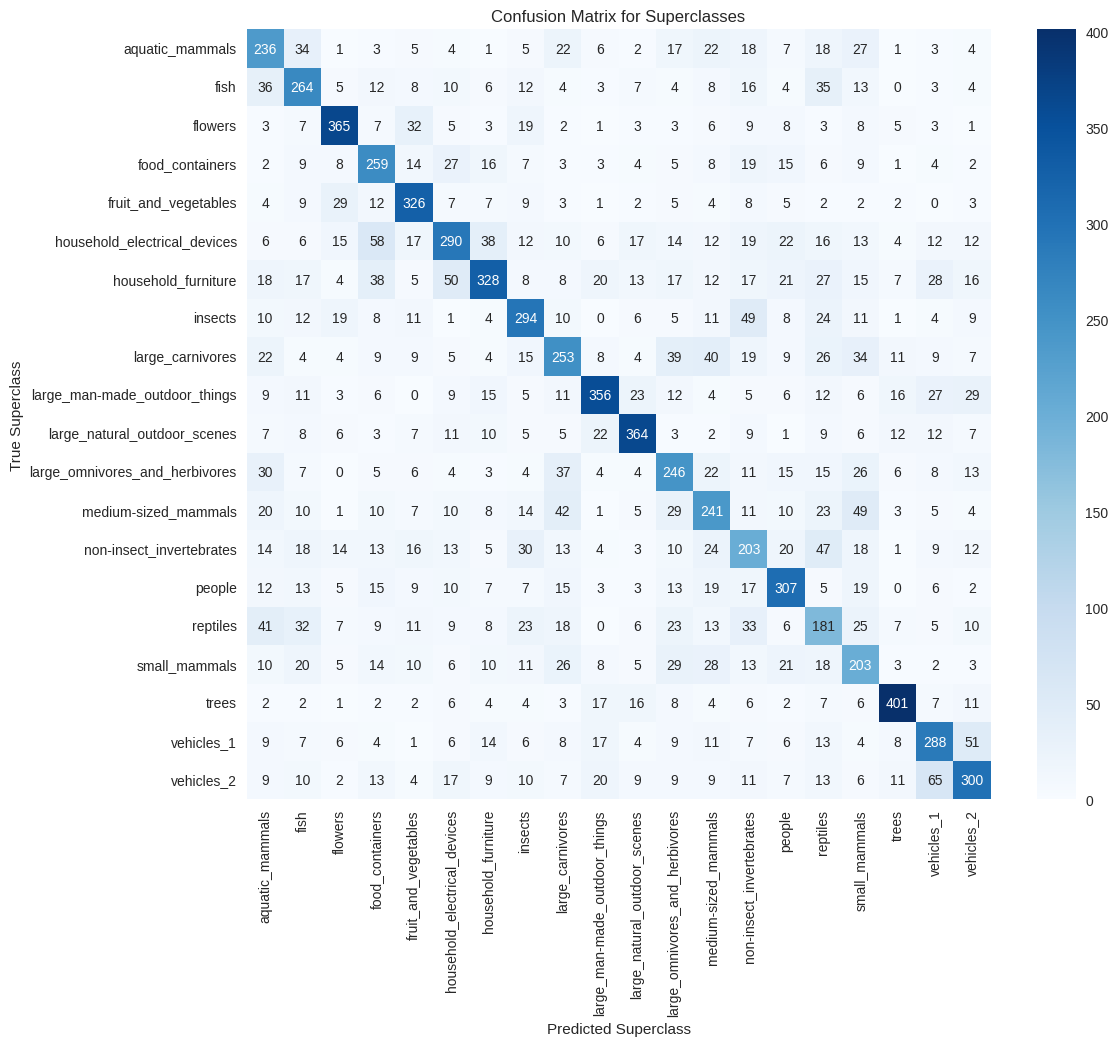

In [15]:
# Confusion matrix for superclass

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)


cm_superclass = confusion_matrix(pred_superclass_labels, true_superclass_labels)

# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_superclass, annot=True, xticklabels=superclass_to_classes.keys(), yticklabels=superclass_to_classes.keys(), cmap="Blues", fmt="d")
plt.xlabel("Predicted Superclass")
plt.ylabel("True Superclass")
plt.title("Confusion Matrix for CIFAR-100 Classification")
plt.title("Confusion Matrix for Superclasses")
plt.show()

####  Childclass confusion matrix

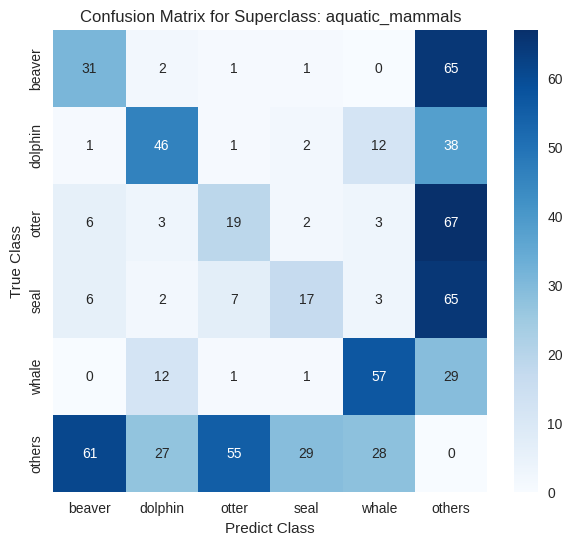

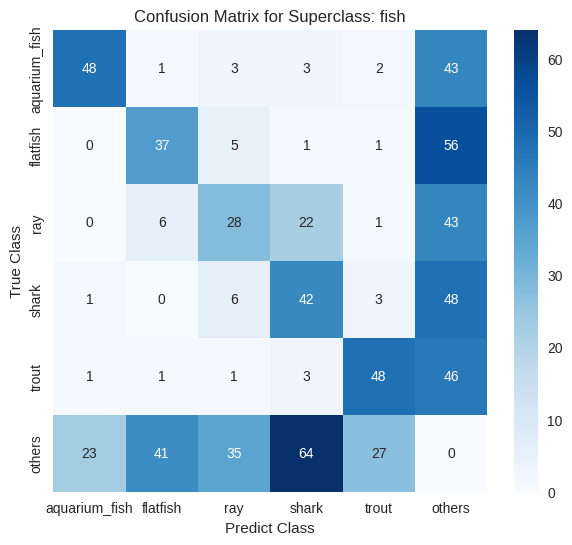

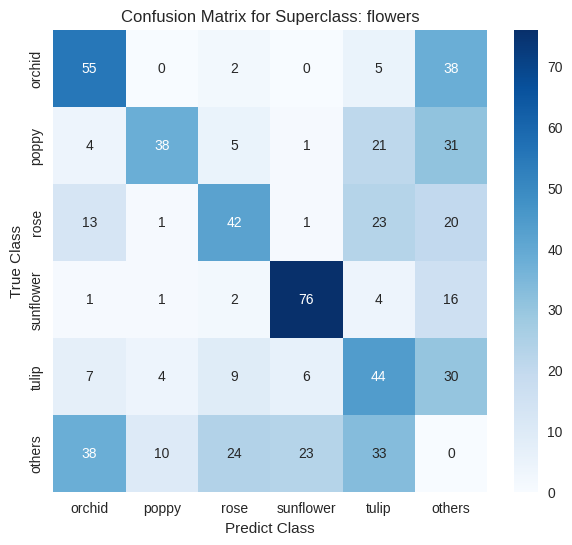

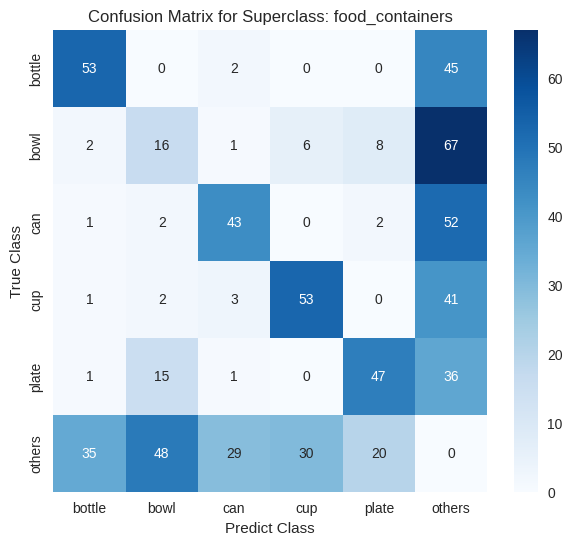

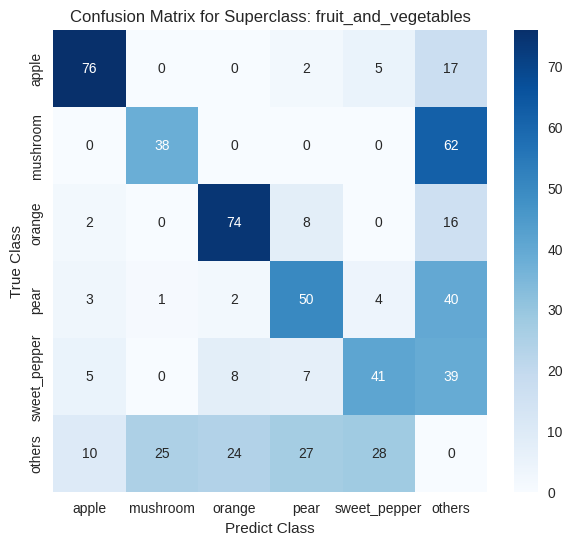

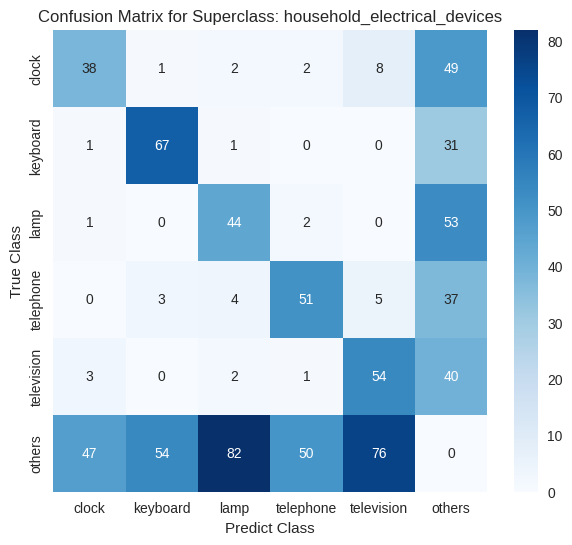

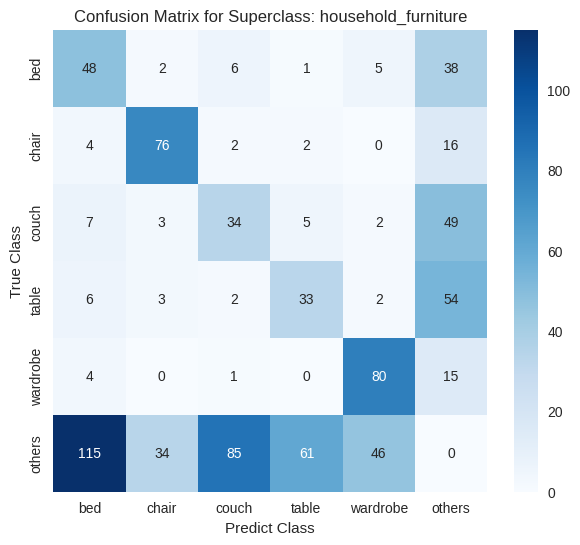

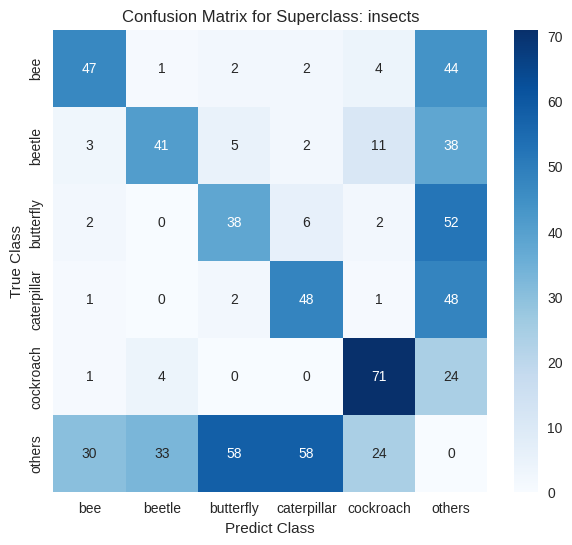

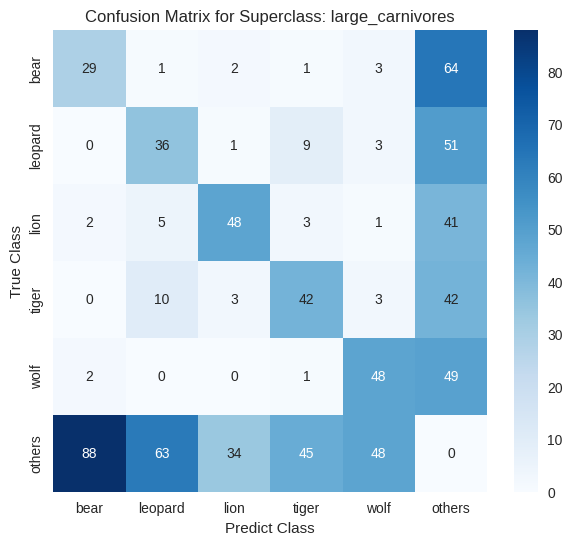

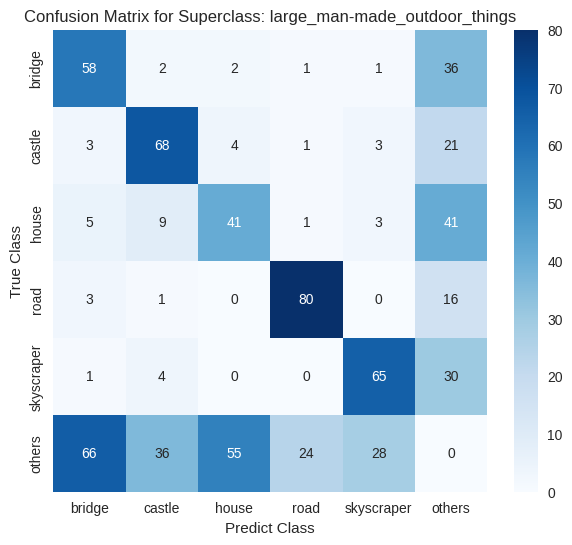

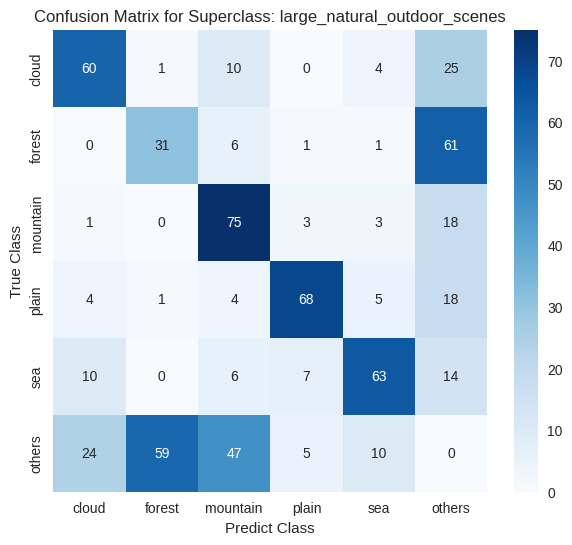

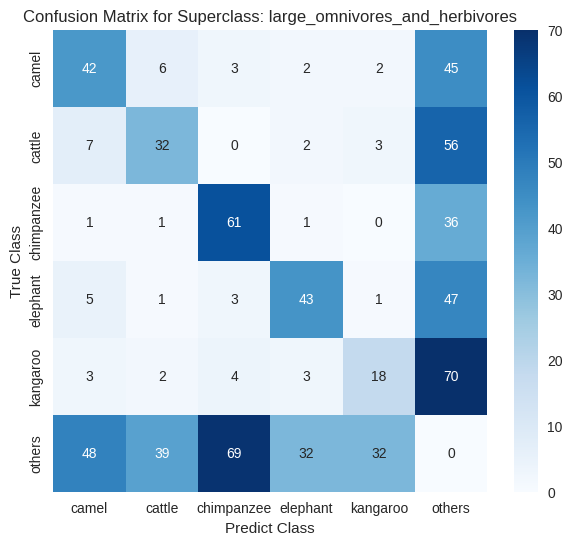

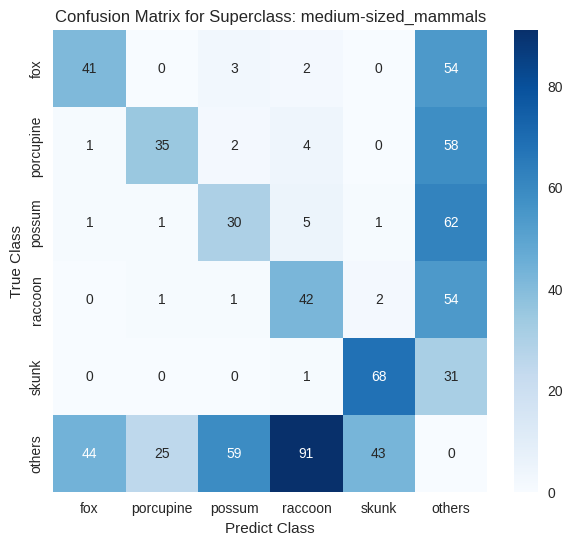

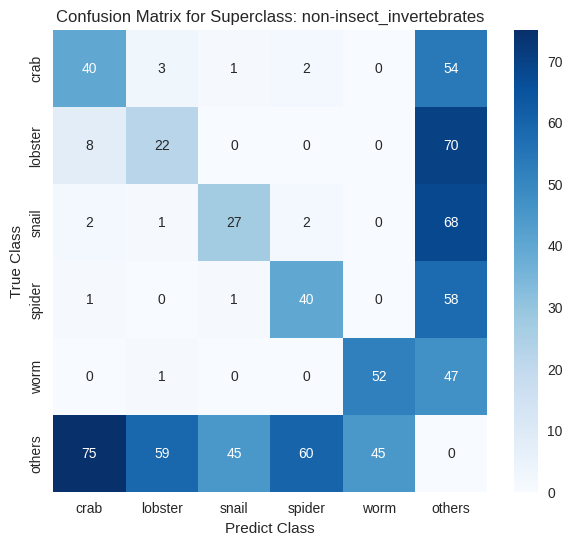

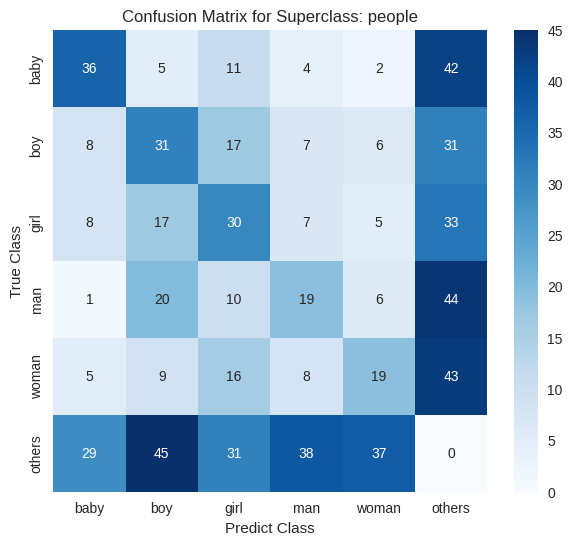

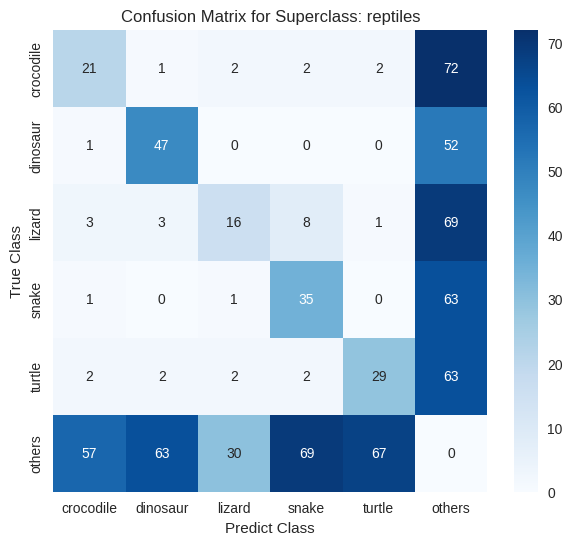

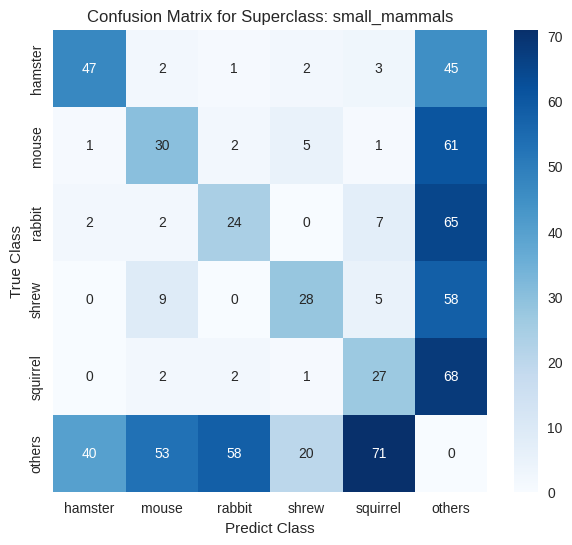

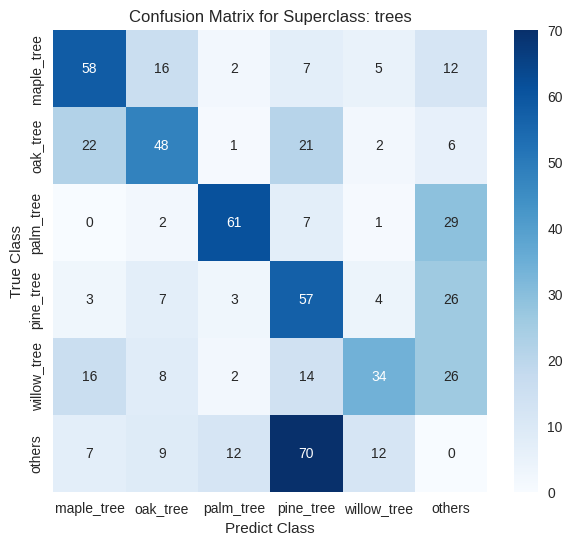

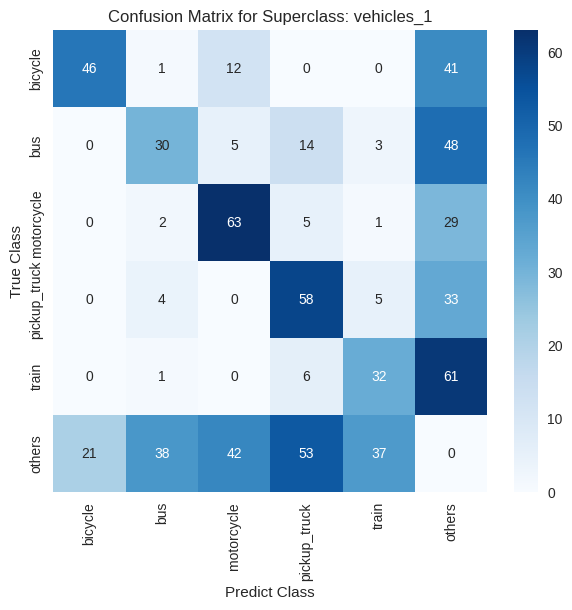

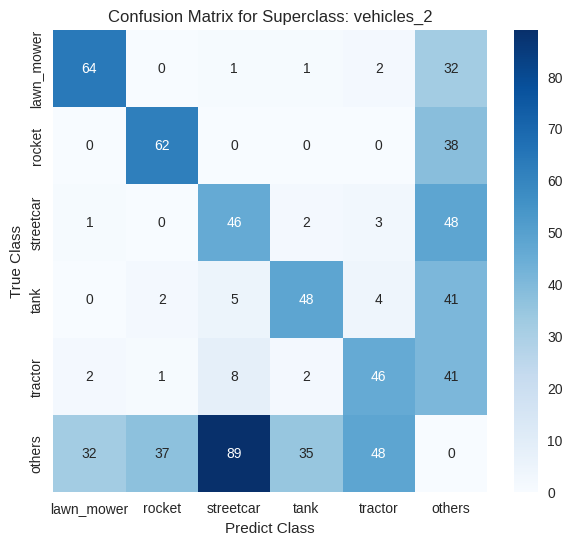

In [16]:
# Confusion matrix for superclass
true_class_labels = list_class_label(true_labels)
pred_class_labels = list_class_label(pred_labels)

superclass = {
    'aquatic_mammals': { 'true_label': [], 'pred_label': [] },
    'fish': { 'true_label': [], 'pred_label': [] },
    'flowers': { 'true_label': [], 'pred_label': [] },
    'food_containers': { 'true_label': [], 'pred_label': [] },
    'fruit_and_vegetables': { 'true_label': [], 'pred_label': [] },
    'household_electrical_devices': { 'true_label': [], 'pred_label': [] },
    'household_furniture': { 'true_label': [], 'pred_label': [] },
    'insects': { 'true_label': [], 'pred_label': [] },
    'large_carnivores': { 'true_label': [], 'pred_label': [] },
    'large_man-made_outdoor_things': { 'true_label': [], 'pred_label': [] },
    'large_natural_outdoor_scenes': { 'true_label': [], 'pred_label': [] },
    'large_omnivores_and_herbivores': { 'true_label': [], 'pred_label': [] },
    'medium-sized_mammals': { 'true_label': [], 'pred_label': [] },
    'non-insect_invertebrates': { 'true_label': [], 'pred_label': [] },
    'people': { 'true_label': [], 'pred_label': [] },
    'reptiles': { 'true_label': [], 'pred_label': [] },
    'small_mammals': { 'true_label': [], 'pred_label': [] },
    'trees': { 'true_label': [], 'pred_label': [] },
    'vehicles_1': { 'true_label': [], 'pred_label': [] },
    'vehicles_2': { 'true_label': [], 'pred_label': [] },
}

child_class = test_dataloader.dataset.classes

true_superclass_labels = list_superclass_label(true_labels)
pred_superclass_labels = list_superclass_label(pred_labels)

for true_label, pred_label in zip(true_class_labels, pred_class_labels):
    true_label_superclass = get_super_by_child(true_label)
    pred_label_superclass = get_super_by_child(pred_label)
    if true_label_superclass == pred_label_superclass:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append(pred_label)
    else:
        superclass[f'{true_label_superclass}']['true_label'].append(true_label)
        superclass[f'{true_label_superclass}']['pred_label'].append('others')
        superclass[f'{pred_label_superclass}']['true_label'].append('others')
        superclass[f'{pred_label_superclass}']['pred_label'].append(pred_label)

colors = [
    "Blues", "BuGn", "BuPu", "GnBu", "OrRd", "PuBu", "PuRd", "RdPu", 
    "YlGn", "YlGnBu", "YlOrBr", "YlOrRd", "Oranges", "Purples", "Greens", 
    "Reds", "coolwarm", "cividis", "magma", "viridis"
]

for super_class, class_label in superclass.items():
    classes = superclass_to_classes[super_class] + ['others']
    cm_class = confusion_matrix(class_label['true_label'], class_label['pred_label'], labels=classes)
    # Vẽ confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_class, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt="d")
    plt.xlabel("Predict Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for Superclass: {super_class}")
    plt.show()

## **LOAD MODEL AGAIN** 

In [17]:
# # Load previous checkpoint and assign to initial variables
# checkpoint = torch.load("VisionTransformer_CIFAR100_checkpoint.pt")
# last_epoch = checkpoint["epoch"]
# model = checkpoint["model"].to(device)
# optimizer = checkpoint["optimizer"]
# scheduler = checkpoint["scheduler"]
# train_accs = checkpoint["train_acc"]
# test_accs = checkpoint["test_acc"]

In [18]:
from calflops import calculate_flops
input_shape = (batch_size, channels, image_sz, image_sz)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))



------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.74 M 
fwd MACs:                                                               2.6757 GMACs
fwd FLOPs:                                                              5.3837 GFLOPS
fwd+bwd MACs:                                                           8.0271 GMACs
fwd+bwd FLOPs:                                                          16.151 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module